In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [25]:
# Data agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

Make CNN for MNIST handwritten digit recognition

In [26]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [27]:
# Load the MNIST dataset
trainDataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
testDataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False)


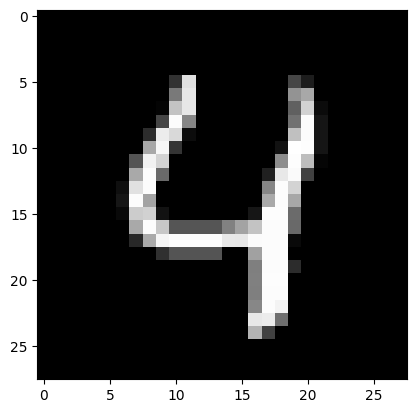

In [28]:
randInd = torch.randint(0,10,(1,))
image, label = testDataset[randInd.item()]
plt.imshow(image.squeeze(), cmap='gray')

CNN Model

In [51]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet,self).__init__()
        
        # LeNet Architecture
        
        # First Block
        self.convBlock1 = nn.Conv2d(channels, 20, (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2), (2,2))

        # Second Block
        self.convBlock2 = nn.Conv2d(20,50, (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2), (2,2))

        # Fully Connected Layer
        self.fullyConnected1 = nn.Linear(800,500)
        self.relu3 = nn.ReLU()

        # Softmax for logit to predictions
        self.fullyConnected2 = nn.Linear(500,classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        # First Block Pass
        x = self.maxpool1(self.relu1(self.convBlock1(x)))
        
        # Second Block Pass
        x = self.maxpool2(self.relu2(self.convBlock2(x)))
        
        # Flatten and pass to Fully Connected Layer
        x = self.relu3(self.fullyConnected1(torch.flatten(x,1)))

        # Softmax Pass
        x = self.fullyConnected2(x)
        output = self.logSoftmax(x)

        return output


Train Init

In [ ]:
# HYPERPARAMETERS
lr = 1e-3
lr = 1e-6
# lr = 0.01
BATCH_SIZE = 32
epochs = 100

# Split data
trainSplit = 0.8
valSplit = 1-trainSplit

trainSamples = int(len(trainDataset) * trainSplit)
valSamples = int(round(len(trainDataset) * valSplit,0))

(trainData, valData) = random_split(trainDataset, [trainSamples, valSamples], generator=torch.Generator().manual_seed(42))

In [ ]:
# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE)


# Batches
trainBatches = len(trainLoader.dataset) // BATCH_SIZE
valBatches = len(valLoader.dataset) // BATCH_SIZE

In [ ]:
# Init

model = LeNet(1,len(trainData.dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lossFn = nn.NLLLoss()

modelRes = {
    "train_loss" : [],
    "train_acc" : [],
    "val_loss" : [],
    "val_acc" : []
}

# Timing
startTime = time.time()

Training and Testing Loop

In [64]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    
    model.train()

     # Create inner tqdm progress bar for batches
    train_batch_progress = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0


    # Forward Pass
    for (x,y) in train_batch_progress:
        (x,y) = (x.to(device),y.to(device))

        # Loss
        pred = model(x)
        loss = lossFn(pred, y)
    
        # Optimizer Zero Grad
        optimizer.zero_grad()
    
        # Loss Backward
        loss.backward()

        # Optimizer Step 
        optimizer.step()

        totalTrainLoss += loss.item()
        totalTrainLoss = loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
    
    model.eval()
    with torch.inference_mode():
        for (xVal, yVal) in valLoader:
            (xVal, yVal) = (xVal.to(device), yVal.to(device))

            # Forward Pass
            valPred = model(xVal)

            # Loss
            valLoss = lossFn(valPred, yVal)
            totalValLoss += valLoss.item()
            totalValLoss = valLoss

            valCorrect += (valPred.argmax(1) == yVal).type(torch.float).sum().item() 

    print(f'Train Loss: {totalTrainLoss} | Val Loss: {totalValLoss} | Val Correct: {valCorrect}')

        



Training Epochs:   1%|          | 1/100 [00:09<15:11,  9.21s/it]

Train Loss: 0.2529171109199524 | Val Loss: 0.3387524485588074 | Val Correct: 10571.0


Training Epochs:   2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

Train Loss: 0.5280950665473938 | Val Loss: 0.20614312589168549 | Val Correct: 11471.0


Training Epochs:   3%|▎         | 3/100 [00:27<14:49,  9.17s/it]

Train Loss: 0.8333460688591003 | Val Loss: 0.16417691111564636 | Val Correct: 11211.0


Training Epochs:   4%|▍         | 4/100 [00:36<14:42,  9.19s/it]

Train Loss: 0.030068326741456985 | Val Loss: 0.06090026721358299 | Val Correct: 11629.0


Training Epochs:   5%|▌         | 5/100 [00:45<14:31,  9.17s/it]

Train Loss: 0.11224565654993057 | Val Loss: 0.2291586995124817 | Val Correct: 11392.0


Training Epochs:   6%|▌         | 6/100 [00:55<14:20,  9.15s/it]

Train Loss: 0.07230720669031143 | Val Loss: 0.15819086134433746 | Val Correct: 11530.0


Training Epochs:   7%|▋         | 7/100 [01:04<14:11,  9.15s/it]

Train Loss: 0.07913820445537567 | Val Loss: 0.1828167587518692 | Val Correct: 11257.0


Training Epochs:   8%|▊         | 8/100 [01:13<14:04,  9.18s/it]

Train Loss: 0.1196083053946495 | Val Loss: 0.13700784742832184 | Val Correct: 11126.0


Training Epochs:   9%|▉         | 9/100 [01:22<13:54,  9.17s/it]

Train Loss: 0.03485090285539627 | Val Loss: 1.8912642002105713 | Val Correct: 11376.0


Training Epochs:  10%|█         | 10/100 [01:31<13:45,  9.17s/it]

Train Loss: 0.03031325154006481 | Val Loss: 0.1278872936964035 | Val Correct: 11440.0


Training Epochs:  11%|█         | 11/100 [01:40<13:35,  9.16s/it]

Train Loss: 0.07062137871980667 | Val Loss: 0.7991161346435547 | Val Correct: 11498.0


Training Epochs:  12%|█▏        | 12/100 [01:49<13:25,  9.15s/it]

Train Loss: 0.3049714267253876 | Val Loss: 2.4100940227508545 | Val Correct: 11321.0


Training Epochs:  13%|█▎        | 13/100 [01:59<13:16,  9.15s/it]

Train Loss: 0.11491122841835022 | Val Loss: 0.2768561840057373 | Val Correct: 11062.0


Training Epochs:  14%|█▍        | 14/100 [02:08<13:06,  9.14s/it]

Train Loss: 0.18851664662361145 | Val Loss: 0.20048925280570984 | Val Correct: 11486.0


Training Epochs:  15%|█▌        | 15/100 [02:17<12:57,  9.15s/it]

Train Loss: 0.10950367897748947 | Val Loss: 0.19008128345012665 | Val Correct: 11290.0


Training Epochs:  16%|█▌        | 16/100 [02:26<12:49,  9.16s/it]

Train Loss: 0.10413263738155365 | Val Loss: 0.116792693734169 | Val Correct: 11369.0


Training Epochs:  17%|█▋        | 17/100 [02:35<12:40,  9.16s/it]

Train Loss: 0.14606709778308868 | Val Loss: 0.22238636016845703 | Val Correct: 11468.0


Training Epochs:  18%|█▊        | 18/100 [02:44<12:30,  9.15s/it]

Train Loss: 0.1268460601568222 | Val Loss: 0.3094710409641266 | Val Correct: 11306.0


Training Epochs:  19%|█▉        | 19/100 [02:54<12:20,  9.14s/it]

Train Loss: 0.1408599466085434 | Val Loss: 0.24537405371665955 | Val Correct: 11465.0


Training Epochs:  20%|██        | 20/100 [03:03<12:09,  9.12s/it]

Train Loss: 0.08032704889774323 | Val Loss: 0.12454605102539062 | Val Correct: 11463.0


Training Epochs:  21%|██        | 21/100 [03:12<12:00,  9.12s/it]

Train Loss: 0.1620122641324997 | Val Loss: 0.6134101152420044 | Val Correct: 11447.0


Training Epochs:  22%|██▏       | 22/100 [03:21<11:51,  9.12s/it]

Train Loss: 0.07960241287946701 | Val Loss: 0.13140372931957245 | Val Correct: 11582.0


Training Epochs:  23%|██▎       | 23/100 [03:30<11:43,  9.13s/it]

Train Loss: 0.05886903405189514 | Val Loss: 0.1415274739265442 | Val Correct: 11178.0


Training Epochs:  24%|██▍       | 24/100 [03:39<11:36,  9.16s/it]

Train Loss: 0.1543637067079544 | Val Loss: 0.11508173495531082 | Val Correct: 11391.0


Training Epochs:  25%|██▌       | 25/100 [03:48<11:26,  9.15s/it]

Train Loss: 0.48525476455688477 | Val Loss: 0.19594120979309082 | Val Correct: 11510.0


Training Epochs:  26%|██▌       | 26/100 [03:58<11:18,  9.17s/it]

Train Loss: 0.10142607986927032 | Val Loss: 0.20122817158699036 | Val Correct: 11334.0


Training Epochs:  27%|██▋       | 27/100 [04:07<11:15,  9.26s/it]

Train Loss: 0.18328233063220978 | Val Loss: 0.2009509801864624 | Val Correct: 11162.0


Training Epochs:  28%|██▊       | 28/100 [04:16<11:10,  9.31s/it]

Train Loss: 0.1291216015815735 | Val Loss: 0.1981608271598816 | Val Correct: 11332.0


Training Epochs:  29%|██▉       | 29/100 [04:26<11:05,  9.37s/it]

Train Loss: 0.06038818135857582 | Val Loss: 0.19987383484840393 | Val Correct: 11385.0


Training Epochs:  30%|███       | 30/100 [04:35<10:57,  9.39s/it]

Train Loss: 0.1295640766620636 | Val Loss: 0.19499263167381287 | Val Correct: 11366.0


Training Epochs:  31%|███       | 31/100 [04:45<10:47,  9.38s/it]

Train Loss: 0.2721027433872223 | Val Loss: 0.49447423219680786 | Val Correct: 10527.0


Training Epochs:  32%|███▏      | 32/100 [04:54<10:39,  9.40s/it]

Train Loss: 0.2195809781551361 | Val Loss: 0.21331745386123657 | Val Correct: 11364.0


Training Epochs:  33%|███▎      | 33/100 [05:04<10:30,  9.40s/it]

Train Loss: 0.06210826709866524 | Val Loss: 0.2618364095687866 | Val Correct: 11160.0


Training Epochs:  34%|███▍      | 34/100 [05:13<10:17,  9.36s/it]

Train Loss: 0.20882059633731842 | Val Loss: 0.2717492878437042 | Val Correct: 10906.0


Training Epochs:  35%|███▌      | 35/100 [05:22<10:04,  9.30s/it]

Train Loss: 3.8912596702575684 | Val Loss: 0.27812865376472473 | Val Correct: 11385.0


Training Epochs:  36%|███▌      | 36/100 [05:31<09:52,  9.26s/it]

Train Loss: 0.19533219933509827 | Val Loss: 0.2152966558933258 | Val Correct: 11207.0


Training Epochs:  37%|███▋      | 37/100 [05:41<09:46,  9.31s/it]

Train Loss: 0.13943889737129211 | Val Loss: 0.19379660487174988 | Val Correct: 11408.0


Training Epochs:  38%|███▊      | 38/100 [05:50<09:40,  9.36s/it]

Train Loss: 0.1314498782157898 | Val Loss: 0.11941708624362946 | Val Correct: 11382.0


Training Epochs:  39%|███▉      | 39/100 [06:00<09:31,  9.37s/it]

Train Loss: 0.09643476456403732 | Val Loss: 0.15613868832588196 | Val Correct: 11391.0


Training Epochs:  40%|████      | 40/100 [06:09<09:27,  9.45s/it]

Train Loss: 0.03252003341913223 | Val Loss: 0.18845677375793457 | Val Correct: 11299.0


Training Epochs:  41%|████      | 41/100 [06:19<09:16,  9.44s/it]

Train Loss: 0.07650067657232285 | Val Loss: 0.11485687643289566 | Val Correct: 11399.0


Training Epochs:  42%|████▏     | 42/100 [06:28<09:06,  9.42s/it]

Train Loss: 0.0 | Val Loss: 0.11271077394485474 | Val Correct: 11423.0


Training Epochs:  43%|████▎     | 43/100 [06:37<08:57,  9.43s/it]

Train Loss: 0.048347700387239456 | Val Loss: 0.15294024348258972 | Val Correct: 11331.0


Training Epochs:  44%|████▍     | 44/100 [06:47<08:50,  9.47s/it]

Train Loss: 0.0589110367000103 | Val Loss: 0.2382291555404663 | Val Correct: 11375.0


Training Epochs:  45%|████▌     | 45/100 [06:56<08:41,  9.48s/it]

Train Loss: 0.006646567489951849 | Val Loss: 0.20645618438720703 | Val Correct: 11359.0


Training Epochs:  46%|████▌     | 46/100 [07:06<08:32,  9.48s/it]

Train Loss: 0.09923184663057327 | Val Loss: 0.25867700576782227 | Val Correct: 10960.0


Training Epochs:  47%|████▋     | 47/100 [07:15<08:22,  9.49s/it]

Train Loss: 0.15814180672168732 | Val Loss: 0.2604697346687317 | Val Correct: 11225.0


Training Epochs:  48%|████▊     | 48/100 [07:25<08:19,  9.61s/it]

Train Loss: 0.03582525625824928 | Val Loss: 0.235571026802063 | Val Correct: 11036.0


Training Epochs:  49%|████▉     | 49/100 [07:35<08:08,  9.58s/it]

Train Loss: 0.6274030804634094 | Val Loss: 0.5465391874313354 | Val Correct: 10340.0


Training Epochs:  50%|█████     | 50/100 [07:44<07:53,  9.47s/it]

Train Loss: 0.32545846700668335 | Val Loss: 0.3184519410133362 | Val Correct: 10928.0


Training Epochs:  51%|█████     | 51/100 [07:54<07:47,  9.54s/it]

Train Loss: 0.15222783386707306 | Val Loss: 0.12407941371202469 | Val Correct: 11215.0


Training Epochs:  52%|█████▏    | 52/100 [08:04<07:48,  9.75s/it]

Train Loss: 0.19835825264453888 | Val Loss: 0.12989002466201782 | Val Correct: 11306.0


Training Epochs:  53%|█████▎    | 53/100 [08:14<07:35,  9.70s/it]

Train Loss: 0.36778104305267334 | Val Loss: 0.1280573010444641 | Val Correct: 11413.0


Training Epochs:  54%|█████▍    | 54/100 [08:23<07:20,  9.58s/it]

Train Loss: 0.12798672914505005 | Val Loss: 0.21129636466503143 | Val Correct: 10998.0


Training Epochs:  55%|█████▌    | 55/100 [08:32<07:07,  9.50s/it]

Train Loss: 0.04382358491420746 | Val Loss: 0.3118146061897278 | Val Correct: 11108.0


Training Epochs:  56%|█████▌    | 56/100 [08:41<06:55,  9.43s/it]

Train Loss: 0.09976132214069366 | Val Loss: 0.20233795046806335 | Val Correct: 11138.0


Training Epochs:  57%|█████▋    | 57/100 [08:51<06:43,  9.39s/it]

Train Loss: 0.09464462101459503 | Val Loss: 0.19417017698287964 | Val Correct: 11432.0


Training Epochs:  58%|█████▊    | 58/100 [09:00<06:36,  9.44s/it]

Train Loss: 0.2641077935695648 | Val Loss: 0.31980520486831665 | Val Correct: 11020.0


Training Epochs:  59%|█████▉    | 59/100 [09:09<06:23,  9.35s/it]

Train Loss: 0.26402735710144043 | Val Loss: 0.3817942142486572 | Val Correct: 10760.0


Training Epochs:  60%|██████    | 60/100 [09:19<06:11,  9.28s/it]

Train Loss: 0.22682321071624756 | Val Loss: 0.29814761877059937 | Val Correct: 11016.0


Training Epochs:  61%|██████    | 61/100 [09:28<06:00,  9.24s/it]

Train Loss: 0.2824069857597351 | Val Loss: 0.11246617138385773 | Val Correct: 11053.0


Training Epochs:  62%|██████▏   | 62/100 [09:37<05:50,  9.22s/it]

Train Loss: 0.12243583798408508 | Val Loss: 0.12498055398464203 | Val Correct: 11364.0


Training Epochs:  63%|██████▎   | 63/100 [09:47<05:48,  9.43s/it]

Train Loss: 0.1402970552444458 | Val Loss: 0.3069201111793518 | Val Correct: 11090.0


Training Epochs:  64%|██████▍   | 64/100 [09:56<05:36,  9.36s/it]

Train Loss: 0.2638929784297943 | Val Loss: 0.1257731020450592 | Val Correct: 11043.0


Training Epochs:  65%|██████▌   | 65/100 [10:06<05:30,  9.43s/it]

Train Loss: 0.20377610623836517 | Val Loss: 0.21336525678634644 | Val Correct: 11205.0


Training Epochs:  66%|██████▌   | 66/100 [10:15<05:22,  9.49s/it]

Train Loss: 0.3672432005405426 | Val Loss: 0.14220494031906128 | Val Correct: 11305.0


Training Epochs:  67%|██████▋   | 67/100 [10:25<05:13,  9.49s/it]

Train Loss: 0.18763107061386108 | Val Loss: 0.23597951233386993 | Val Correct: 10939.0


Training Epochs:  68%|██████▊   | 68/100 [10:34<05:00,  9.39s/it]

Train Loss: 0.21878638863563538 | Val Loss: 0.3029080331325531 | Val Correct: 11083.0


Training Epochs:  69%|██████▉   | 69/100 [10:43<04:52,  9.44s/it]

Train Loss: 0.258541077375412 | Val Loss: 0.34670567512512207 | Val Correct: 10788.0


Training Epochs:  70%|███████   | 70/100 [10:54<04:50,  9.69s/it]

Train Loss: 0.19696322083473206 | Val Loss: 0.34856879711151123 | Val Correct: 10837.0


Training Epochs:  71%|███████   | 71/100 [11:03<04:36,  9.53s/it]

Train Loss: 0.12828953564167023 | Val Loss: 0.19524261355400085 | Val Correct: 11221.0


Training Epochs:  72%|███████▏  | 72/100 [11:12<04:26,  9.54s/it]

Train Loss: 0.11584632843732834 | Val Loss: 0.059647150337696075 | Val Correct: 11173.0


Training Epochs:  73%|███████▎  | 73/100 [11:22<04:16,  9.51s/it]

Train Loss: 0.291568785905838 | Val Loss: 0.1859436333179474 | Val Correct: 11104.0


Training Epochs:  74%|███████▍  | 74/100 [11:31<04:04,  9.39s/it]

Train Loss: 0.46638017892837524 | Val Loss: 0.4882700443267822 | Val Correct: 10313.0


Training Epochs:  75%|███████▌  | 75/100 [11:40<03:52,  9.32s/it]

Train Loss: 0.2807011008262634 | Val Loss: 0.4157498776912689 | Val Correct: 10746.0


Training Epochs:  76%|███████▌  | 76/100 [11:49<03:43,  9.30s/it]

Train Loss: 0.33433157205581665 | Val Loss: 0.48734229803085327 | Val Correct: 10145.0


Training Epochs:  77%|███████▋  | 77/100 [11:59<03:34,  9.34s/it]

Train Loss: 0.33864957094192505 | Val Loss: 0.3713238835334778 | Val Correct: 10460.0


Training Epochs:  78%|███████▊  | 78/100 [12:08<03:25,  9.32s/it]

Train Loss: 0.1526155173778534 | Val Loss: 0.13720721006393433 | Val Correct: 10878.0


Training Epochs:  79%|███████▉  | 79/100 [12:17<03:15,  9.30s/it]

Train Loss: 0.24426144361495972 | Val Loss: 0.062284089624881744 | Val Correct: 11151.0


Training Epochs:  80%|████████  | 80/100 [12:26<03:03,  9.20s/it]

Train Loss: 0.18446190655231476 | Val Loss: 0.4230034351348877 | Val Correct: 10468.0


Training Epochs:  81%|████████  | 81/100 [12:36<02:54,  9.20s/it]

Train Loss: 0.06499162316322327 | Val Loss: 0.1477273404598236 | Val Correct: 11181.0


Training Epochs:  82%|████████▏ | 82/100 [12:45<02:46,  9.22s/it]

Train Loss: 0.108253613114357 | Val Loss: 0.20571522414684296 | Val Correct: 11141.0


Training Epochs:  83%|████████▎ | 83/100 [12:54<02:38,  9.29s/it]

Train Loss: 0.2917086184024811 | Val Loss: 0.1299826204776764 | Val Correct: 11104.0


Training Epochs:  84%|████████▍ | 84/100 [13:04<02:30,  9.41s/it]

Train Loss: 0.22054487466812134 | Val Loss: 0.2838183045387268 | Val Correct: 11238.0


Training Epochs:  85%|████████▌ | 85/100 [13:14<02:22,  9.48s/it]

Train Loss: 0.26316577196121216 | Val Loss: 0.38868001103401184 | Val Correct: 10911.0


Training Epochs:  86%|████████▌ | 86/100 [13:23<02:12,  9.45s/it]

Train Loss: 0.12712639570236206 | Val Loss: 0.22756001353263855 | Val Correct: 11190.0


Training Epochs:  87%|████████▋ | 87/100 [13:33<02:04,  9.59s/it]

Train Loss: 0.138389453291893 | Val Loss: 0.12754058837890625 | Val Correct: 11251.0


Training Epochs:  88%|████████▊ | 88/100 [13:44<01:58,  9.90s/it]

Train Loss: 0.12380362302064896 | Val Loss: 0.27395540475845337 | Val Correct: 11047.0


Training Epochs:  89%|████████▉ | 89/100 [13:53<01:46,  9.69s/it]

Train Loss: 0.3425276279449463 | Val Loss: 0.3670960068702698 | Val Correct: 10726.0


Training Epochs:  90%|█████████ | 90/100 [14:02<01:36,  9.66s/it]

Train Loss: 0.3433966636657715 | Val Loss: 0.5185450911521912 | Val Correct: 10411.0


Training Epochs:  91%|█████████ | 91/100 [14:12<01:25,  9.55s/it]

Train Loss: 0.42070162296295166 | Val Loss: 0.5189907550811768 | Val Correct: 10237.0


Training Epochs:  92%|█████████▏| 92/100 [14:21<01:15,  9.46s/it]

Train Loss: 0.3275339603424072 | Val Loss: 0.37915605306625366 | Val Correct: 10876.0


Training Epochs:  93%|█████████▎| 93/100 [14:30<01:06,  9.45s/it]

Train Loss: 0.2738719582557678 | Val Loss: 0.37140679359436035 | Val Correct: 10796.0


Training Epochs:  94%|█████████▍| 94/100 [14:40<00:57,  9.55s/it]

Train Loss: 0.31545281410217285 | Val Loss: 0.28046026825904846 | Val Correct: 11138.0


Training Epochs:  95%|█████████▌| 95/100 [14:50<00:47,  9.52s/it]

Train Loss: 0.3385157585144043 | Val Loss: 0.2549605965614319 | Val Correct: 10726.0


Training Epochs:  96%|█████████▌| 96/100 [14:59<00:38,  9.58s/it]

Train Loss: 0.3138388693332672 | Val Loss: 0.27362674474716187 | Val Correct: 10673.0


Training Epochs:  97%|█████████▋| 97/100 [15:09<00:28,  9.49s/it]

Train Loss: 0.31385183334350586 | Val Loss: 0.478374183177948 | Val Correct: 10241.0


Training Epochs:  98%|█████████▊| 98/100 [15:18<00:18,  9.43s/it]

Train Loss: 0.2184602916240692 | Val Loss: 0.3767787218093872 | Val Correct: 10919.0


Training Epochs:  99%|█████████▉| 99/100 [15:27<00:09,  9.38s/it]

Train Loss: 0.38901787996292114 | Val Loss: 0.14571639895439148 | Val Correct: 10838.0


Training Epochs: 100%|██████████| 100/100 [15:37<00:00,  9.37s/it]

Train Loss: 0.3876250386238098 | Val Loss: 0.21892422437667847 | Val Correct: 11234.0


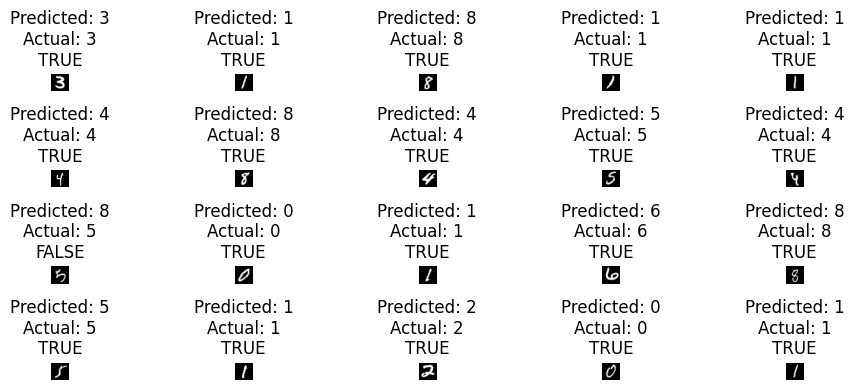

In [113]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    model.eval()
    with torch.inference_mode():
        prediction = model(image.unsqueeze(0).to(device))


    predicted_class = torch.argmax(prediction).item()
    # print("Ground truth label:", label)
    # print(f"Predicted Digit: {predicted_class}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Save Model

In [114]:
# Save Model
import os

baseName = "HDR.pth"
i = 1
fileName = baseName

while os.path.exists(fileName):
    fileName = f"{os.path.splitext(baseName)[0]}_{i}.pth"
    i += 1

torch.save(model.state_dict(), fileName)

(-0.5, 715.5, 367.5, -0.5)

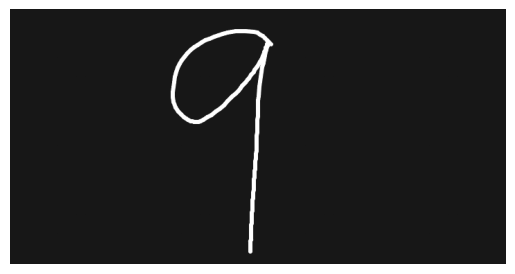

In [9]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

x = "iVBORw0KGgoAAAANSUhEUgAAAswAAAFwCAYAAACsMS2JAAAAAXNSR0IArs4c6QAAIABJREFUeF7t3X+oX3X9B/D3DS3dFtMivab7Y/OmVHOMYObkollLDCWWKDdMSaiwYnHLZA0LTSlYsYKLw1olmqZ0cSyJElGxsstmDmma/yhX98eqW6P8UcwGhn5537635u7n9+f8ep/z+MDY99s95/1+vR+vIzzv2ftzzsjJJ5/8evAhQIAAAQIECBAgQKClwIjA7MogQIAAAQIECBAg0F5AYHZ1ECBAgAABAgQIEOggIDC7PAgQIECAAAECBAgIzK4BAgQIECBAgAABAoMJuMM8mJuzCBAgQIAAAQIEGiIgMDek0ZZJgAABAgQIECAwmIDAPJibswgQIECAAAECBBoiIDA3pNGWSYAAAQIECBAgMJiAwDyYm7MIECBAgAABAgQaIiAwN6TRlkmAAAECBAgQIDCYgMA8mJuzCBAgQIAAAQIEGiIgMDek0ZZJgAABAgQIECAwmIDAPJibswgQIECAAAECBBoiIDA3pNGWSYAAAQIECBAgMJiAwDyYm7MIECBAgAABAgQaIiAwN6TRlkmAAAECBAgQIDCYgMA8mJuzCBAgQIAAAQIEGiIgMDek0ZZJgAABAgQIECAwmIDAPJibswgQIECAAAECBBoiIDA3pNGWSYAAAQIECBAgMJiAwDyYm7MIECBAgAABAgQaIiAwN6TRlkmAAAECBAgQIDCYgMA8mJuzCBAgQIAAAQIEGiIgMDek0ZZJgAABAgQIECAwmIDAPJibswgQIECAAAECBBoiIDA3pNGWSYAAAQIECBAgMJiAwDyYm7MIECBAgAABAgQaIiAwN6TRlkmAAAECBAgQIDCYgMA8mJuzCBCoicDExMT8Ss4999xw8cUXh2XLlg28stdffz0cOnQovPjii+HAgQPzf+Jn4f8+8v9/4YUX5o/1IUCAAIHqCwjM1e+RCgkQyEDgyGB8ySWXhKVLl2Yw6nBDvPbaa+FPf/pTuP/++8Mf/vCH8NRTT4Vnn312uEGdTYAAAQKZCwjMmZMakACBKgjEgPzFL34xrFixIhxzzDFVKKmnGuJd6meeeSZs3rw5PP744z2d4yACBAgQyFdAYM7X1+gECBQkEANy3FYR/8SQnPrnH//4R/jQhz70320dqa9H/QQIEEhZQGBOuXtqJ9BwgYW7yCtXrqytxOTkZJienq7t+iyMAAECKQgIzCl0SY0ECPxXYOFO8sKe5CbQPP300+H666+3RaMJzbZGAgQqKSAwV7ItiiJA4EiBGI4/85nPhNWrV2cOc/DgwfCrX/0q7N69e37s+PfC0yz6nWxhK8jRf8dtIvET//e3vOUt4d3vfndYsmRJv8PP32netm3bwPX1PaETCBAgQGBeQGB2IRAgUEmBrO8kZxmMswI744wzwpo1a8JZZ50VLr300vCOd7yjp6FjqI9bNQYN9j1N4iACBAgQ+K+AwOxiIECgMgLxTuzNN9+c2Z3keEc2/lm4e1yZhbYp5Lrrrgsf//jHw2mnnda11LhNY8OGDV2PcwABAgQIDC8gMA9vaAQCBIYUiHeTF+4oDzNUDJE//OEPh9pWMcz8WZwbf2m4/fbbw/Lly7sOF38ZiHeafQgQIEAgXwGBOV9foxMg0EEghuR4V3WYx8At3EGu25Mk9uzZ09MzpN1p9p8YAQIE8hcQmPM3NgMBAkcIZPEFvoU7yXULyUdfKPFuc/S66KKLOt5x3r9/f1i/fr3rjAABAgRyEhCYc4I1LAEC/xGIWwuuvPLKEL/gNsyj4Op6J7mX62Tjxo1h06ZNHfd2257Ri6RjCBAgMJiAwDyYm7MIEOgicMIJJ4Sf/vSnYe3atQNbNeVOci9AcdvKwhaWdsfbntGLpGMIECDQv4DA3L+ZMwgQ6CJw9dVXh69//evhuOOOG8gqfpFtmOchDzRpAifF0Dw1NTX/+u92H9szEmikEgkQSE5AYE6uZQomUF2Bc845J2zZsiXEv/v9xIC88Bi4fs9t0vFnn332vHGn0OxOc5OuCGslQKAIAYG5CGVzEKi5wLHHHjv/tryxsbG+VxrD3Q033JDMs5L7XmAOJ/SyPcOd5hzgDUmAQGMFBObGtt7CCWQjEO903n333eH444/vecAmf4GvZ6QuB/ayPcMXAbPSNg4BAk0XEJibfgVYP4EhBHbt2tVxa8CRQ8/OzoZbb7013HPPPUPM6NQjBeL2jPjFyiVLlrSFEZpdMwQIEBheQGAe3tAIBBoncOGFF4Zvfetb4ZRTTum69sceeyxs3bo1xL99shf4y1/+0nVQobkrkQMIECDQUUBgdoEQINCzQHxU3K9//eswOjra9ZzDhw/PPynjjjvu6HqsAwYTeOCBB3p+bJ/QPJixswgQIBAFBGbXAQECPQn086i4uP3ikksuCS+99FJPYztoMIG5ubkwMjLS08kHDhwI69at6+lYBxEgQIDAGwUEZlcEAQIdBfp5VFwMcJs3bw4PPfQQ1QIEetmOcWQZvfzLQAFlm4IAAQLJCQjMybVMwQSKEej3UXH+yb+YvizMEp9OEr902etn27ZtIf7xIUCAAIH+BQTm/s2cQaD2AvGRZQ8++GA48cQTu671X//6V/jEJz7hOcpdpbI9IG57WbZsWdtBYziOr9KOn/jLjLCcrb/RCBBoloDA3Kx+Wy2BrgL93LmMoe2CCy4Ir776atdxHZCdwMzMTMeXxMS+jI+PZzehkQgQINBwAYG54ReA5RM4UuC6664L8U+3j0fFdRPK9+d//vOfw5ve9Ka2k8Qv98Uv+fkQIECAQDYCAnM2jkYhkLzA3r17Q9yK0enjUXHVaHOnL/vFV41v2LChGoWqggABAjUREJhr0kjLIDCMQC9hOYa0D3zgAx4VNwx0Rud2CsyTk5Pze5Z9CBAgQCA7AYE5O0sjEUhSoJfXW99yyy3hm9/8ZpLrq1vR8Yt8U1NTbZdlO0bdOm49BAhUQUBgrkIX1ECgJIFewvKll17qCRgl9afVtPv37w/HH39824o8a7lCzVIKAQK1ERCYa9NKCyHQn0C3sBy/NBbDsi+P9eea59HdXoUdw/T69evzLMHYBAgQaKSAwNzItlt00wW67Vk+ePBgWLNmTdOZKrf+bq/Cjm9ZvPPOOytXt4IIECCQuoDAnHoH1U+gT4FuYXn37t3zd5Z9qifQ7VXYtmNUr2cqIkCgHgICcz36aBUEehLo9pxlYbknxlIO6vZlv7h1Jn7hz4cAAQIEshcQmLM3NSKBSgp0e4OfsFzJtv23qIcffjisXr26bZE7duwIN954Y7UXoToCBAgkKiAwJ9o4ZRPoRyC+kCRuxWj3sWe5H83ij+3Wv1jRpk2bws6dO4svzowECBBogIDA3IAmWyKBTvuW/VN+9a+PbneX4wrOO++88Oyzz1Z/MSokQIBAggICc4JNUzKBfgSeeuqpcNJJJ7U9xYsu+tEs59huX/Z77bXXwjvf+c5yijMrAQIEGiAgMDegyZbYXIFuX/LzUpLqXxvdvuwXV/DKK6+EVatWVX8xKiRAgECiAgJzoo1TNoFuAt2+5Ldt27YQ//hUW6CX7Rg/+MEPwg033FDthaiOAAECCQsIzAk3T+kE2gl0+5KYL/mlce106+PCKvzyk0Y/VUmAQLoCAnO6vVM5gZYCxx57bIj7lk888cSWP/clv3QunG77zxdWYmtNOj1VKQECaQoIzGn2TdUE2grMzMyEsbGxtj/3Jb80Lp5uW2qOXIU3/KXRU1USIJCugMCcbu9UTmCRwDnnnBPuu+++tjLuRKZz0TzzzDNh+fLlXQv2LwZdiRxAgACBoQUE5qEJDUCgOgIxLMfQ3Oqzffv28I1vfKM6xaqkrUAvX/RbONkbGl1IBAgQyF9AYM7f2AwEChG4+uqrw9atW1vOFZ/ju3bt2kLqMMlwAitXrgx79uzpeRBf+OuZyoEECBAYWEBgHpjOiQSqI3DCCSeEffv2heOOO25RUYcPH54Pyy+99FJ1ClZJW4Fue9CPPtE2GxcTAQIE8hcQmPM3NgOB3AUeeOCBtneQt2zZEu64447cazDB8ALd9qC3msEX/oZ3NwIBAgS6CQjM3YT8nEDFBd7znveERx55pGWVjz32WNi4cWPFV6C8BYFOe9DbKQnMrh8CBAjkLyAw529sBgK5Ctx2223h4osvbjlHDMsxNPtUX6DTHvQXXnghvO1tb1u0iKeffjps2LCh+otTIQECBBIXEJgTb6Dymy3Q6U1ws7OzYXx8vNlAiaw+7kGPLyl585vfvKjiuAe91d70eODk5GSYnp5OZJXKJECAQLoCAnO6vVM5gTA1NRUmJiZaSqxfvz7s37+fUgICv/3tb8O73vWulpXee++94fLLL2/5M9sxEmiuEgkQqIWAwFyLNlpEEwU63V2Odx3j3Uef6gtce+21YfPmzS0LjU8+OeaYY8Lq1asX/VyPq99bFRIgUB8Bgbk+vbSShgl0ermF11+ncTF8+MMfDnfddVfbYj/1qU+FHTt2zIfmoz+2Y6TRY1USIFAPAYG5Hn20igYKxJeRtPq485jGxbBq1arwy1/+Mpx44oktC46vxj7//PNDuz7bjpFGn1VJgEA9BATmevTRKhomEPctx/3LrT7uLqdxMTzxxBPh1FNPbVlsfMnMWWedFWIvd+3ateiYAwcOzP/MhwABAgSKERCYi3E2C4FMBdp92c9jxjJlzm2wBx98MKxZs6bl+C+//HL4yEc+Ep5//vn5L3S2+sXIvyLk1hoDEyBAoKWAwOzCIJCgQLt/prevtfrNPOWUU8Lvf//7toVeddVV4aGHHpr/+XXXXTf/5+jPtm3bQvzjQ4AAAQLFCAjMxTibhUBmAp22Y9jXmhlzbgNt2rQpfO1rX2s5/s033xxuvfXW//6s3b8k+MUot/YYmAABAu4wuwYI1EFgz549YeXKlYuW4p/p0+hufEHJSSedtKjYuAXj3HPPfcP/Hr/4t3z58kXHXnrppWH37t1pLFiVBAgQqIGAO8w1aKIlNEvAdox0+x2/wHd0KF5YTau7xu167Yud6V4DKidAIE0BgTnNvqm6oQK2Y6Tb+Pvvvz+8733va7uAVttpPFIu3X6rnACBegkIzPXqp9XUXMDTMdJr8LHHHhviNox2z1uOK4rbK+I2iyM/8U60R8ql128VEyBQTwGBuZ59taqaCuzduzfEV2If/fElsOo2/IEHHghr165tW2C7Zyp7pFx1e6oyAgSaJyAwN6/nVpywgD2taTXvnHPOCffdd1/bolvdWV442CPl0uq1agkQqLeAwFzv/lpdjQTsX06vmTEsx9Dc6vP444+Hj370o20X5ZFy6fVbxQQI1FdAYK5vb62sZgIPP/xwWL169aJVeZxcNRt99dVXh61bt7YsLv5LQadtGvEkj5SrZl9VRYBAMwUE5mb23aoTFPjjH/8YjjnmmEWVeyZv9Zp5wgknhH379oXjjjtuUXGHDx+eD8svvfRSx8Jtv6leX1VEgEBzBQTm5vbeyhMT8IixdBoWw3K7ty5u2bIl3HHHHV0Xo99diRxAgACBwgQE5sKoTURgcIF2jxg7dOhQOP300wcf2JmZCzzxxBPh1FNPbTnuY489FjZu3Nh1To+U60rkAAIECBQqIDAXym0yAoMJeMTYYG5Fn9XusX8LdcSwHENzt49+dxPycwIECBQrIDAX6202AgMJCFADsRV6Uru7wgtFxG0aF110UU81eaRcT0wOIkCAQGECAnNh1CYiMLiAR4wNblfEmfFlMvHucrvPiy++GNasWRNeffXVnsrR756YHESAAIHCBATmwqhNRGBwAQFqcLsizuy0FePvf/97eO9739tXGR4p1xeXgwkQIJC7gMCcO7EJCAwv0C5ArVu3LsRXK/uUJ/DUU0+Fk046qWUBL7/8cjjzzDP7Ls4j5fomcwIBAgRyFRCYc+U1OIFsBASobByzHmXXrl0h7l1u9xn0GdkeKZd1p4xHgACB4QQE5uH8nE2gEAEBqhDmvibp9kSMQcOyR8r11QYHEyBAoBABgbkQZpMQGFxAgBrcLq8zu4XluE0mbpcZ5OOJKIOoOYcAAQL5CgjM+foancDQAgLU0ISZDpBnWI6FeqRcpu0yGAECBDIREJgzYTQIgfwEBKj8bPsduVtY3r17d4hbMYb5eCLKMHrOJUCAQD4CAnM+rkYlkJmAAJUZ5VADdXsxyTDbMI4szCPlhmqTkwkQIJCLgMCcC6tBCWQnIEBlZznMSO36EMfMKizHsTwRZZguOZcAAQL5CAjM+bgalUBmAgJUZpQDD9TpWcsHDx6cf4tfVh9PRMlK0jgECBDITkBgzs7SSARyERCgcmHtedBOWzEGfTFJu8nbvWI763l6XrwDCRAgQGBeQGB2IRCosIBHypXbnHYBdqGqQZ+13G9gznLLR7miZidAgECaAgJzmn1TdUMEPFKu3EZ3eirG/v37w/r16zMtsN0vSFk8fSPTQg1GgACBhgkIzA1ruOWmJeCRcuX1q9O+5by2SLT7BUlgLu86MDMBAgSigMDsOiBQYQGPlCunObt27Qrxbm+7T9ZbMRbm8S8K5fTbrAQIEOgmIDB3E/JzAiUKzM7OhmXLli2qIK/AVuJSKzN1WWE5AvgXhcpcBgohQIDAGwQEZhcEgQoLeKRcsc3ptA0jVpL3l+8E5mL7bTYCBAj0KiAw9yrlOAIlCHikXDHo8WkY8c5y/LvdJ++wHOe1BaeYfpuFAAEC/QoIzP2KOZ5AgQICc/7Y3V55HSso6kt37baDTE5Ohunp6fwxzECAAAECLQUEZhcGgQoLCMz5NqfdFogjZy0qLMc52wVme9bzvQ6MToAAgW4CAnM3IT8nUKKAwJwffqdnLC/MWsQ2jCNX2K4mgTm/68DIBAgQ6EVAYO5FyTEEShIQmPOBr2JYjit97rnnwtKlSxctet26dfNfOPQhQIAAgXIEBOZy3M1KoCcBgbknpr4O6iUsb9u2LcQ/RX/0u2hx8xEgQKA3AYG5NydHEShFQIDKlr2XsFzm9gf9zrbfRiNAgEBWAgJzVpLGIZCDgOcwZ4fa7YUkcctDDMtlbX1o95a/ovdRZyduJAIECNRHQGCuTy+tpIYC+/btC6Ojo4tWVuZd0BSZu4XlgwcPhjVr1pS6NK/FLpXf5AQIEOgoIDC7QAhUWMBzeYdvTrewXJU7uF5aMnyvjUCAAIG8BATmvGSNSyADAa9KHg6x257lqoTluMrZ2dmwbNmyRQv20pLhrgFnEyBAIAsBgTkLRWMQyEmg3T/TF/kyjZyWlvuw3cJy1QztV8/9kjABAQIEBhYQmAemcyKB/AXavbb50KFD4fTTT8+/gERn6PYGv6qF5cjsCRmJXmzKJkCgEQICcyPabJGpCqxYsSLEO6VHf/7973+H0047LdVl5Vp3u18yFiatYlgWmHO9JAxOgACBoQUE5qEJDUAgX4F2dx7tbV3s3i0sV2nP8tHVu8Oc739HRidAgMAwAgLzMHrOJVCAQLu9uFW9U1oAScsp2t2NXzi4ymHZHeayrhrzEiBAoDcBgbk3J0cRKE1g48aN4fvf/37L+T2P+X8sTz75ZDj55JNbOlU9LAvMpf3nZWICBAj0JCAw98TkIALlCrR7lvC2bdtC/NPkzymnnBJ+/vOfh3iHud0nhV8sbMlo8lVs7QQIVF1AYK56h9RHIITQ7qkPKdw5zbOB73//+8P27duTD8vuMOd5lRibAAECwwsIzMMbGoFA7gKd9uemcPc0D6DLL7883HLLLR2Hvu2228JXv/rVPKbPfEx3mDMnNSABAgQyExCYM6M0EIF8Bdptyzh48GBYs2ZNvpNXbPRrr702bN68uWNVf/vb38Lq1asrVnn7cgTmZFqlUAIEGiggMDew6ZacpkC7t/7F1TTpLvOePXvCypUrOzbx6aefDhs2bEiq0QJzUu1SLAECDRMQmBvWcMtNV6DTtowm7GWOz1j+yU9+EpYsWdKxid/+9rfDd7/73eQaLTAn1zIFEyDQIAGBuUHNttT0BR5++OG22wymp6dDfJlJHT/ttqMcvdYvfOEL4d57702SQGBOsm2KJkCgIQICc0MabZn1EDj77LPDXXfdFZYvX95yQXXbmvHRj3403HTTTSE+Oq7TJ95h37RpU/jd736XbKMF5mRbp3ACBBogIDA3oMmWWC+BTq9/PnToUDj99NNrseBOLyI5coExLMdgPTc3l/S6Beak26d4AgRqLiAw17zBlldPgampqRC/BNjqk/p+5l5eRLKw7ueffz7EXyDq8BGY69BFayBAoK4CAnNdO2tdtRaIXwCMb7drt1XhF7/4Rfj0pz+dnEEvLyKJi4p3k2+88cZ5g7p8BOa6dNI6CBCoo4DAXMeuWlMjBD72sY+F733ve23X+sgjj4QrrrgiGYteXkQSF1PXLzcKzMlcqgolQKCBAgJzA5tuyfUR6PTUjLjKVLZnfOUrXwlf+tKXOjbmlVdeCVdeeWXYvXt3fRp4xEoE5lq21aIIEKiJgMBck0ZaRjMF4taMu+++O5xxxhltAaocmletWhXuvPPOMDY21rGB+/fvD+vXr691kwXmWrfX4ggQSFxAYE68gconEAV+9KMfhUsuuaQtRtW2Z8SgfM0114RPfvKTXRuY6otIui7sqAME5n7FHE+AAIHiBATm4qzNRCBXgXvuuSd88IMfbDtHFb4I2E9QjgtJ+UUk/TZbYO5XzPEECBAoTkBgLs7aTARyF9i7d2+I2zTafeL2jPhyk/h3kZ/4OusHH3yw69aLhZriUzA++9nPJv0ikn59BeZ+xRxPgACB4gQE5uKszUSgEIFuoTm+3OSqq64q7Mtz8TnJ8e73cccd19P6X3rppXDBBRck/yKSnhZ7xEHtAnN8EU3smQ8BAgQIlCcgMJdnb2YCuQl0254RJ3766afD9ddfHx5//PHc6ti1a1dfLxZ59tlnw0UXXRTiEzGa9Ilf2nz00UcXLfn111/v+lrwJjlZKwECBMoSEJjLkjcvgZwFun0RME7/z3/+c/7Ld/FLgVl+4l7q73znOz2HvZ/97GfzT8vYs2dPlmUkM9Zll10Wtm/fvqjeeNd57dq1yaxDoQQIEKirgMBc185aF4EQ5u9adnrk3ALSk08+GW666aaht2nEL/XFu8qjo6M9+f/4xz8OO3bsCPEV103+RPv4i8vRn2gT32joQ4AAAQLlCgjM5fqbnUDuAvGu7cqVK3uaZ9AA2+/TL5577rn5fdRND8oLTdm3b1/LXzI2bdoUdu7c2VPvHESAAAEC+QkIzPnZGplAZQTia7Tj84zf+ta39lxT3D/717/+NXz+85+ff6pGqydrxNAb74x2e/HIwqTx6Rdf/vKXM98C0vOiKnpgdBkZGVlU3XnnnRfivm4fAgQIEChXQGAu19/sBAoV6Oduc9aFTU9Ph8nJyayHTX68pUuXhnjHvdWn160tySNYAAECBCouIDBXvEHKI5C1QL+PeRt2/sOHD4crrrhi6P3Rw9ZR5fM9g7nK3VEbAQIEQhCYXQUEGijQ74tEBiWanZ0NF154YeMeE9evl8Dcr5jjCRAgUKyAwFyst9kIVEqg3y/r9Vr8oF8e7HX8uh0nMNeto9ZDgEDdBATmunXUeggMIBCD8+233x7OPPPMAc7+3ynx8XSf+9znPP2iT0WBuU8whxMgQKBgAYG5YHDTEaiyQNyq8fa3v33+iRhxr/Ott97a9ZnKcdvF3XffHeJd5aa9oS+rXgrMWUkahwABAvkICMz5uBqVAAECPQsIzD1TOZAAAQKlCAjMpbCblAABAv8TEJhdDQQIEKi2gMBc7f6ojgCBBggIzA1osiUSIJC0gMCcdPsUT4BAHQQE5jp00RoIEKizgMBc5+5aGwECSQgIzEm0SZEECDRYQGBucPMtnQCBaggIzNXogyoIECDQTkBgdm0QIECgZAGBueQGmJ4AAQJdBARmlwgBAgRKFhCYS26A6QkQICAwuwYIECBQbQGBudr9UR0BAgTcYXYNECBAoGQBgbnkBpieAAEC7jC7BggQIFBtAYG52v1RHQECBNxhdg0QIECgZIF2gfn0008Phw4dKrk60xMgQICAwOwaIECAQIkCZ5xxRnj00UcXVfD666+HU045pcTKTE2AAAECCwICs2uBAAECJQpcdtllYfv27YsqiHed165dW2JlpiZAgAABgdk1QIAAgQoI3HTTTeGaa65ZVMmOHTvCjTfeWIEKlUCAAAEC7jC7BggQIFCiwL59+8Lo6OiiCjZt2hR27txZYmWmJkCAAAF3mF0DBAgQqIDA3NxcGBkZWVTJeeedF5599tkKVKgEAgQIEHCH2TVAgACBkgSWLl0annvuuZazt7rrXFKZpiVAgEDjBQTmxl8CAAgQKFPAM5jL1Dc3AQIEehMQmHtzchQBAgRyERCYc2E1KAECBDIVEJgz5TQYAQIE+hMQmPvzcjQBAgTKEBCYy1A3JwECBP5fQGB2KRAgQKD6AgJz9XukQgIEaiwgMNe4uZZGgEBtBATm2rTSQggQSFFAYE6xa2omQKBpAgJz0zpuvQQIVEpAYK5UOxRDgACBlgICswuDAAECJQoIzCXim5oAAQI9CgjMPUI5jAABAnkICMx5qBqTAAEC2QoIzNl6Go0AAQJ9CQjMfXE5mAABAqUICMylsJuUAAEC/xEQmF0JBAgQqL6AwFz9HqmQAIEaCwjMNW6upREgUBsBgbk2rbQQAgRSFBCYU+yamgkQaJqAwNy0jlsvAQKVEhCYK9UOxRAgQKClgMDswiBAgECJAgJzifimJkCAQI8CAnOPUA4jQIBAHgICcx6qxiRAgEC2AgJztp5GI0CAQF8CAnNfXA4mQIBAKQICcynsJiVAgMB/BARmVwIBAgSqLyAwV79HKiRAoMYCAnONm2tpBAjURkBgrk0rLYQAgRQFBOYUu6ZmAgSaJiAwN63j1kuAQKUEBOZKtUMxBAgQaCkgMLswCBA99nGKAAAOsUlEQVQgUJLAxMREmJqaajn76OhoSVWZlgABAgSOFhCYXRMECBAoSaBdYJ6dnQ3j4+MlVWVaAgQIEBCYXQMECBCoiMDMzEwYGxtbVM3k5GSYnp6uSJXKIECAAAF3mF0DBAgQKElgbm4ujIyMLJp93bp14cCBAyVVZVoCBAgQcIfZNUCAAIGKCPjCX0UaoQwCBAh0EXCH2SVCgACBkgQE5pLgTUuAAIE+BQTmPsEcToAAgawEBOasJI1DgACBfAUE5nx9jU6AAIG2AgKzi4MAAQJpCAjMafRJlQQI1FBAYK5hUy2JAIFaCgjMtWyrRREgkIKAwJxCl9RIgACBEARmVwEBAgRKEhCYS4I3LQECBPoUEJj7BHM4AQIEshDwWuwsFI1BgACBYgQE5mKczUKAAIE3CHgttguCAAEC6QgIzOn0SqUECNRIwGuxa9RMSyFAoPYCAnPtW2yBBAhUUcBrsavYFTURIECgtYDA7MogQIBACQK+8FcCuikJECAwoIDAPCCc0wgQIDCMgMA8jJ5zCRAgUKyAwFyst9kIECAwLyAwuxAIECCQjoDAnE6vVEqAQI0EBOYaNdNSCBCovYDAXPsWWyABAlUUEJir2BU1ESBAoLWAwOzKIECAQAkCAnMJ6KYkQIDAgAIC84BwTiNAgMAwAgLzMHrOJUCAQLECAnOx3mYjQIDAvIDA7EIgQIBAOgICczq9UikBAjUSEJhr1ExLIUCg9gICc+1bbIEECFRRQGCuYlfURIAAgdYCArMrgwABAiUICMwloJuSAAECAwoIzAPCOY0AAQKDCkxMTISpqamWp4+Ojg46rPMIECBAICcBgTknWMMSIECgncDMzEwYGxtb9OPZ2dkwPj4OjgABAgQqJiAwV6whyiFAoP4Cc3NzYWRkZNFCJycnw/T0dP0BrJAAAQKJCQjMiTVMuQQIpC9g/3L6PbQCAgSaJSAwN6vfVkuAQAUEBOYKNEEJBAgQ6ENAYO4Dy6EECBDIQkBgzkLRGAQIEChOQGAuztpMBAgQmBcQmF0IBAgQSEtAYE6rX6olQKAGAgJzDZpoCQQINEpAYG5Uuy2WAIEqCAjMVeiCGggQINC7gMDcu5UjCRAgkImAwJwJo0EIECBQmIDAXBi1iQgQIPAfAYHZlUCAAIG0BATmtPqlWgIEaiAgMNegiZZAgECjBATmRrXbYgkQKFtgYmIiTE1NtSxjdHS07PLMT4AAAQItBARmlwUBAgQKFJiZmQljY2OLZpydnQ3j4+MFVmIqAgQIEOhVQGDuVcpxBAgQyEBgbm4ujIyMLBppcnIyTE9PZzCDIQgQIEAgawGBOWtR4xEgQKCDgP3LLg8CBAikJyAwp9czFRMgkLCAwJxw85ROgEBjBQTmxrbewgkQKENAYC5D3ZwECBAYTkBgHs7P2QQIEOhLQGDui8vBBAgQqISAwFyJNiiCAIGmCAjMTem0dRIgUCcBgblO3bQWAgQqLyAwV75FCiRAgMAiAYHZRUGAAIECBQTmArFNRYAAgYwEBOaMIA1DgACBXgQE5l6UHEOAAIFqCQjM1eqHaggQqLmAwFzzBlseAQK1FBCYa9lWiyJAoKoCAnNVO6MuAgQItBcQmF0dBAgQKFBAYC4Q21QECBDISEBgzgjSMAQIEOhFQGDuRckxBAgQqJaAwFytfqiGAIGaCwjMNW+w5REgUEsBgbmWbbUoAgSqKiAwV7Uz6iJAgEB7AYHZ1UGAAIECBQTmArFNRYAAgYwEBOaMIA1DgACBbgITExNhamqq5WGjo6PdTvdzAgQIEChJQGAuCd60BAg0T6BdYJ6dnQ3j4+PNA7FiAgQIJCIgMCfSKGUSIJC+wMzMTBgbG1u0kMnJyTA9PZ3+Aq2AAAECNRUQmGvaWMsiQKB6AnNzc2FkZGRRYevWrQsHDhyoXsEqIkCAAIF5AYHZhUCAAIGCBHzhryBo0xAgQCBjAYE5Y1DDESBAoJ2AwOzaIECAQJoCAnOafVM1AQIJCgjMCTZNyQQIELAlwzVAgACB4gQE5uKszUSAAIEsBdxhzlLTWAQIEOggIDC7PAgQIJCmgMCcZt9UTYBAggICc4JNUzIBAgRsyXANECBAoDgBgbk4azMRIEAgSwF3mLPUNBYBAgRsyXANECBAoHYCAnPtWmpBBAhUUaDda7FjraOjo1UsWU0ECBAg8P8CArNLgQABAgUItHst9uzsbBgfHy+gAlMQIECAwKACAvOgcs4jQIBAHwLtXos9OTkZpqen+xjJoQQIECBQtIDAXLS4+QgQaKSAL/w1su0WTYBATQQE5po00jIIEKi2gMBc7f6ojgABAp0EBGbXBwECBAoQEJgLQDYFAQIEchIQmHOCNSwBAgSOFBCYXQ8ECBBIV0BgTrd3KidAICEBgTmhZimVAAECRwkIzC4JAgQIFCAgMBeAbAoCBAjkJCAw5wRrWAIECBwpIDC7HggQIJCugMCcbu9UToBAQgICc0LNUioBAgSOEhCYXRIECBAoQEBgLgDZFAQIEMhJQGDOCdawBAgQOFJAYHY9ECBAIF0BgTnd3qmcAIGEBATmhJqlVAIECBwlIDC7JAgQIFCAgMBcALIpCBAgkJOAwJwTrGEJECBwpIDA7HogQIBAugICc7q9UzkBAgkJCMwJNUupBAgQOEpAYHZJECBAoAABgbkAZFMQIEAgJwGBOSdYwxIgQGBBYGJiIkxNTbUEGR0dBUWAAAECFRcQmCveIOURIJC+wMzMTBgbG1u0kNnZ2TA+Pp7+Aq2AAAECNRcQmGveYMsjQKB8gbm5uTAyMrKokMnJyTA9PV1+gSogQIAAgY4CArMLhAABAjkL2L+cM7DhCRAgkLOAwJwzsOEJECAgMLsGCBAgkLaAwJx2/1RPgEACAgJzAk1SIgECBDoICMwuDwIECOQsIDDnDGx4AgQI5CwgMOcMbHgCBAgIzK4BAgQIpC0gMKfdP9UTIJCAgMCcQJOUSIAAAVsyXAMECBAoT0BgLs/ezAQIEMhCwB3mLBSNQYAAgQ4CArPLgwABAmkLCMxp90/1BAgkICAwJ9AkJRIgQKCDgMDs8iBAgEDOAgJzzsCGJ0CAQM4CAnPOwIYnQICAwOwaIECAQNoCAnPa/VM9AQIJCAjMCTRJiQQIELAlwzVAgACB8gQE5vLszUyAAIEsBNxhzkLRGAQIEOggIDC7PAgQIJC2gMCcdv9UT4BAAgICcwJNUiIBAgQ6CAjMLg8CBAjkKDAxMRGmpqZazjA6OprjzIYmQIAAgawEBOasJI1DgACBFgIzMzNhbGxs0U9mZ2fD+Pg4MwIECBBIQEBgTqBJSiRAIF2Bubm5MDIysmgBk5OTYXp6Ot2FqZwAAQINEhCYG9RsSyVAoHgB+5eLNzcjAQIEshYQmLMWNR4BAgSOEBCYXQ4ECBBIX0BgTr+HVkCAQIUFBOYKN0dpBAgQ6FFAYO4RymEECBAYREBgHkTNOQQIEKiWgMBcrX6ohgCBmgkIzDVrqOUQINBIAYG5kW23aAIEihIQmIuSNg8BAgTyExCY87M1MgECBILA7CIgQIBA+gICc/o9tAICBCosIDBXuDlKI0CAQI8CAnOPUA4jQIDAIAIC8yBqziFAgEC1BATmavVDNQQI1ExAYK5ZQy2HAIFGCgjMjWy7RRMgUJSAwFyUtHkIECCQn4DAnJ+tkQkQIOBLf64BAgQI1EBAYK5BEy2BAIHqCrjDXN3eqIwAAQK9CgjMvUo5jgABAgMICMwDoDmFAAECFRMQmCvWEOUQIFAvAYG5Xv20GgIEmikgMDez71ZNgEBBAgJzQdCmIUCAQI4CAnOOuIYmQICAwOwaIECAQPoCAnP6PbQCAgQqLCAwV7g5SiNAgECPAgJzj1AOI0CAwCACAvMgas4hQIBAtQQE5mr1QzUECNRMQGCuWUMthwCBRgoIzI1su0UTIFCEwKpVq8Lu3btbTrVu3bpw4MCBIsowBwECBAgMKSAwDwnodAIECLQT+M1vfhPOPPPMlj+OYfqVV16BR4AAAQIJCAjMCTRJiQQIpCewZMmS8Pzzz7cs/Jlnngnnn39+eotSMQECBBoqIDA3tPGWTYBAvgIrVqwIe/fubTnJueee2zZM51uV0QkQIEBgEAGBeRA15xAgQKAHAV/46wHJIQQIEEhAQGBOoElKJEAgTQGBOc2+qZoAAQJHCwjMrgkCBAjkJCAw5wRrWAIECBQsIDAXDG46AgSaIyAwN6fXVkqAQL0FBOZ699fqCBAoUUBgLhHf1AQIEMhQQGDOENNQBAgQOFJAYHY9ECBAoB4CAnM9+mgVBAhUUEBgrmBTlESAAIEBBATmAdCcQoAAgV4EBOZelBxDgACB6gsIzNXvkQoJEEhUQGBOtHHKJkCAwFECArNLggABAjkJCMw5wRqWAAECBQsIzAWDm44AgeYICMzN6bWVEiBQbwGBud79tToCBEoUEJhLxDc1AQIEMhQQmDPENBQBAgSOFBCYXQ8ECBCoh4DAXI8+WgUBAhUUEJgr2BQlESBAYAABgXkANKcQIECgF4EDBw6EY4899g2Hvvrqq2HFihW9nO4YAgQIEKiIgMBckUYogwCB+gls3bo1XH311W9Y2B133BG2bNlSv8VaEQECBGosIDDXuLmWRoBA+QIxNF922WXzhezcuVNYLr8lKiBAgEDfAgJz32ROIECAAAECBAgQaJKAwNykblsrAQIECBAgQIBA3wICc99kTiBAgAABAgQIEGiSgMDcpG5bKwECBAgQIECAQN8CAnPfZE4gQIAAAQIECBBokoDA3KRuWysBAgQIECBAgEDfAgJz32ROIECAAAECBAgQaJKAwNykblsrAQIECBAgQIBA3wICc99kTiBAgAABAgQIEGiSgMDcpG5bKwECBAgQIECAQN8CAnPfZE4gQIAAAQIECBBokoDA3KRuWysBAgQIECBAgEDfAgJz32ROIECAAAECBAgQaJKAwNykblsrAQIECBAgQIBA3wICc99kTiBAgAABAgQIEGiSwP8BuWzL5brdvRMAAAAASUVORK5CYII="

# x = x.split(",")[1]
# print(x)


x = base64.b64decode(x)
image_array = np.frombuffer(x, np.uint8)
image = plt.imread(BytesIO(image_array))

plt.imshow(image)
plt.axis("off")